In [2]:
import os, random, warnings, math
warnings.filterwarnings("ignore")

import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    XGB_AVAILABLE = False
    print("xgboost not found; using GradientBoostingClassifier as the fallback.")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT       = os.getcwd()
TRAIN_DIR  = os.path.join(ROOT, "train")
VAL_DIR    = None       
TEST_DIR   = os.path.join(ROOT, "test")   
USE_SPLIT  = True       
IMG_SIZE   = 226
BATCH_SIZE = 32
EPOCHS     = 20
AUTOTUNE   = tf.data.AUTOTUNE


CLASS_NAMES = [
    "Black-grass","Charlock","Cleavers","Common Chickweed","Common wheat","Fat Hen",
    "Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse",
    "Small-flowered Cranesbill","Sugar beet"
]
print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.20.0


In [3]:
def list_class_folders(root, allowed):
    found = []
    for d in sorted(os.listdir(root)):
        p = os.path.join(root, d)
        if os.path.isdir(p) and d in allowed:
            found.append(d)
    if not found:
        raise RuntimeError(f"No valid class folders in {root}. Expected one or more of: {allowed}")
    return found

CLASS_NAMES = list_class_folders(TRAIN_DIR, CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected {NUM_CLASSES} classes:\n{CLASS_NAMES}")

def make_ds_from_directory(path, subset=None, validation_split=None, shuffle=True, seed=SEED):
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",
        class_names=CLASS_NAMES,         
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=seed,
        validation_split=validation_split,
        subset=subset,
    )

if USE_SPLIT or not VAL_DIR:
    train_ds = make_ds_from_directory(TRAIN_DIR, subset="training",   validation_split=0.20, shuffle=True)
    val_ds   = make_ds_from_directory(TRAIN_DIR, subset="validation", validation_split=0.20, shuffle=False)
else:
    train_ds = make_ds_from_directory(TRAIN_DIR, shuffle=True)
    val_ds   = make_ds_from_directory(VAL_DIR,   shuffle=False)

def prepare(ds, training=False):
    ds = ds.cache()
    if training: ds = ds.shuffle(1000, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)

Detected 12 classes:
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.


# Building the baseline CNN model



We used the value activation function, we could try using different activation functions. But because training takes so long we can just talk about others in the report


Output layer, outputs a softmax that we will use for the SMV and XGBoost classifer 

Epochs value just results in continous training hence it takes lonh


In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.10),
        layers.RandomZoom(0.10),
    ],
    name="augment",
)

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    
    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x); x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    
    x = layers.Dense(256, activation="relu", name="embedding")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)
    return keras.Model(inputs, outputs, name="baseline_cnn")

cnn = build_cnn()
cnn.compile(optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5),
]

history = cnn.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3513 - loss: 1.9114 - val_accuracy: 0.0000e+00 - val_loss: 3.7342 - learning_rate: 0.0010
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5145 - loss: 1.4292 - val_accuracy: 0.0000e+00 - val_loss: 5.1415 - learning_rate: 0.0010
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5750 - loss: 1.2678 - val_accuracy: 0.0000e+00 - val_loss: 7.4906 - learning_rate: 0.0010
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6184 - loss: 1.1222 - val_accuracy: 0.0326 - val_loss: 4.5719 - learning_rate: 5.0000e-04
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6461 - loss: 1.0350 - val_accuracy: 0.0389 - val_loss: 3.1660 - learning_rate: 5.0000e-04
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6674 - loss: 0.9827 - val_accuracy: 0.1000 - val_loss: 3.6808 - learning_rate: 5.0000e-04
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - acc

In [ ]:

def numpy_Conversion(ds):
    x_Values = []
    y_Values = []

    for x, y in ds:
        x_Values.append(x.numpy())
        y_Values.append(y.numpy())
    
    return np.concatenate(x_Values, 0), np.concatenate(y_Values, 0)

def labels_and_Pred(model, ds):
    y_Prob = model.predict(ds, verbose = 0)
    _, y_T_OneHot = numpy_Conversion(ds)
    y_T_Idx = np.argmax(y_T_OneHot, axis=1)
    y_Pred_Idx = np.argmax(y_Prob, axis=1)
    return y_T_Idx, y_Pred_Idx, y_Prob

def extract_features(ds, feature_model):
    features, labels = [], []
    for x, y in ds:
        z = feature_model.predict(x, verbose=0)
        features.append(z)
        labels.append(y.numpy())
    X = np.concatenate(features, 0)
    Y = np.concatenate(labels, 0)
    y_Idx = np.argmax(Y, axis=1)
    return X, y_Idx


def micro_roc_auc(y_T_Idx, y_Prob,num_Classes):
    y_T_Bin = label_binarize(y_T_Idx, classes=np.arange(num_Classes))
    n, m, _ = roc_curve(y_T_Bin.ravel(), y_Prob.ravel())
    return n, m, auc(n,m)


In [29]:
y_T_Val, y_Pred_Val_Cnn, y_Prob_Val_Cnn = labels_and_Pred(cnn, val_ds)
f1_Micro_Cnn_Val = f1_score(y_T_Val, y_Pred_Val_Cnn, average="micro")


feature_extractor = keras.Model(inputs=cnn.input, outputs=cnn.get_layer("embedding").output)
X_tr, y_tr = extract_features(train_ds, feature_extractor)
X_val, y_val = extract_features(val_ds, feature_extractor)


svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", probability=True, random_state=SEED))
svm_clf.fit(X_tr, y_tr)
y_pred_val_svm = svm_clf.predict(X_val)
y_prob_val_svm = svm_clf.predict_proba(X_val)
f1_micro_svm_val = f1_score(y_val, y_pred_val_svm, average="micro")


if XGB_AVAILABLE:
    xgb_clf = XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        objective="multi:softprob", num_class=NUM_CLASSES,
        eval_metric="mlogloss", tree_method="hist", random_state=SEED
    )
else:
    xgb_clf = GradientBoostingClassifier(random_state=SEED)

xgb_clf.fit(X_tr, y_tr)
y_pred_val_xgb = xgb_clf.predict(X_val)
y_prob_val_xgb = xgb_clf.predict_proba(X_val)
f1_micro_xgb_val = f1_score(y_val, y_pred_val_xgb, average="micro")
xgb_name = "XGBoost" if XGB_AVAILABLE else "GradientBoosting (fallback)"

print(f"Baseline CNN micro F1: {f1_Micro_Cnn_Val:.4f}")
print(f"CNN & SVM micro F1: {f1_micro_svm_val:.4f}")
print(f"CNN & {xgb_name:23} micro F1: {f1_micro_xgb_val:.4f}")


Baseline CNN micro F1: 0.8084
CNN & SVM micro F1: 0.9021
CNN & XGBoost                 micro F1: 0.9832


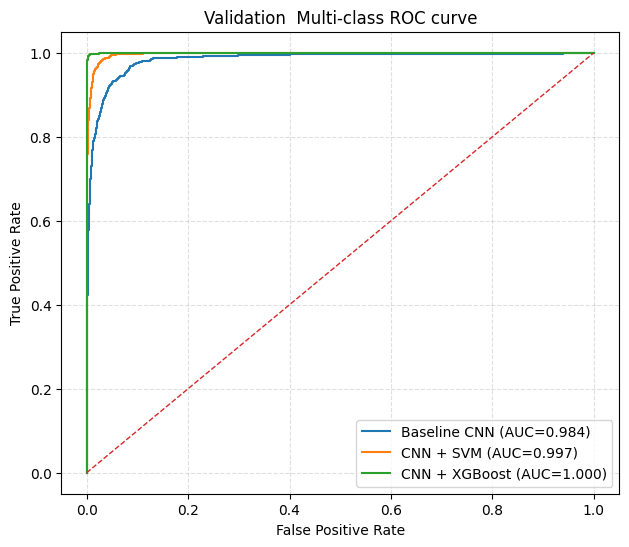

,Model,F1_micro VALUE,ROC_AUC_micro VALUE
2,CNN & XGBoost,0.983158,0.999561
1,CNN & SVM,0.902105,0.997136
0,Baseline CNN,0.808421,0.983625


In [60]:

fpr_cnn_v, tpr_cnn_v, auc_cnn_v = micro_roc_auc(y_T_Val, y_Prob_Val_Cnn, NUM_CLASSES)
fpr_svm_v, tpr_svm_v, auc_svm_v = micro_roc_auc(y_val, y_prob_val_svm, NUM_CLASSES)
fpr_xgb_v, tpr_xgb_v, auc_xgb_v = micro_roc_auc(y_val, y_prob_val_xgb, NUM_CLASSES)
# Plot ROC curves
plt.figure(figsize=(7.2,6))
plt.plot(fpr_cnn_v, tpr_cnn_v, label=f"Baseline CNN (AUC={auc_cnn_v:.3f})")
plt.plot(fpr_svm_v, tpr_svm_v, label=f"CNN + SVM (AUC={auc_svm_v:.3f})")
plt.plot(fpr_xgb_v, tpr_xgb_v, label=f"CNN + {xgb_name} (AUC={auc_xgb_v:.3f})")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Validation  Multi-class ROC curve")
plt.legend(loc="lower right"); plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

display(pd.DataFrame({
    "Model": ["Baseline CNN", "CNN & SVM", f"CNN & {xgb_name}"],
    "F1_micro VALUE": [f1_Micro_Cnn_Val, f1_micro_svm_val, f1_micro_xgb_val],
    "ROC_AUC_micro VALUE": [auc_cnn_v, auc_svm_v, auc_xgb_v],
}).sort_values("F1_micro VALUE", ascending=False))


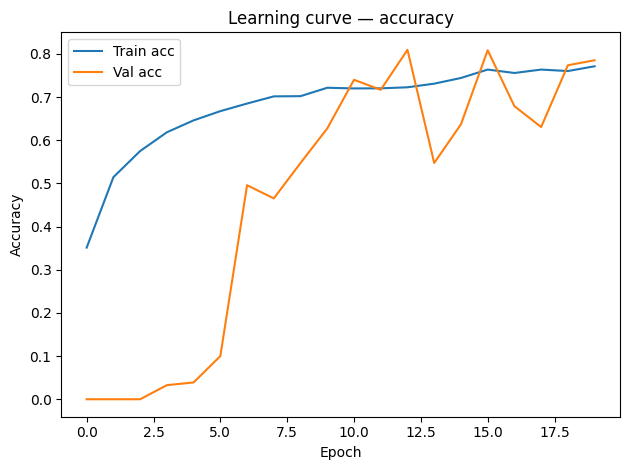

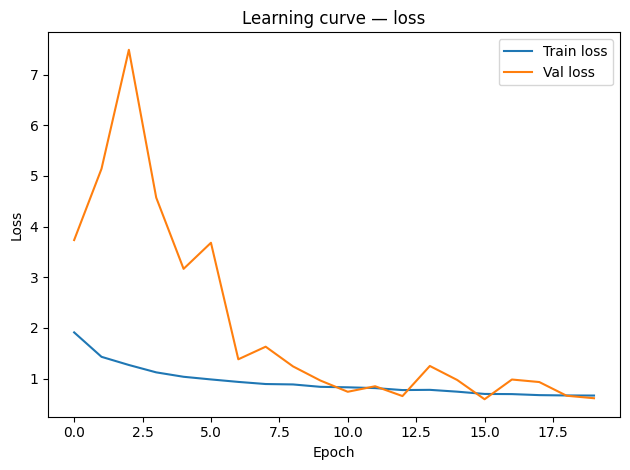

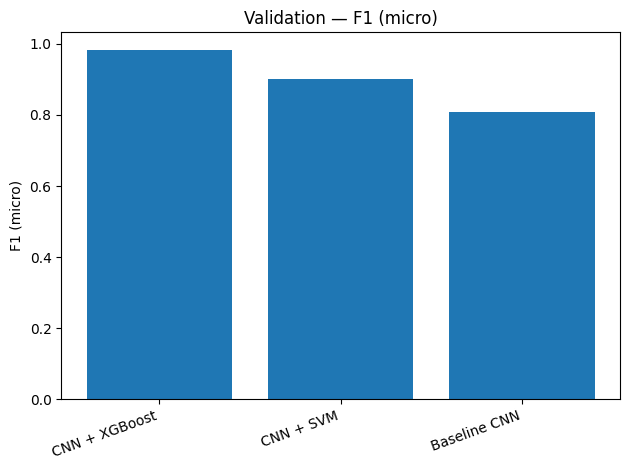

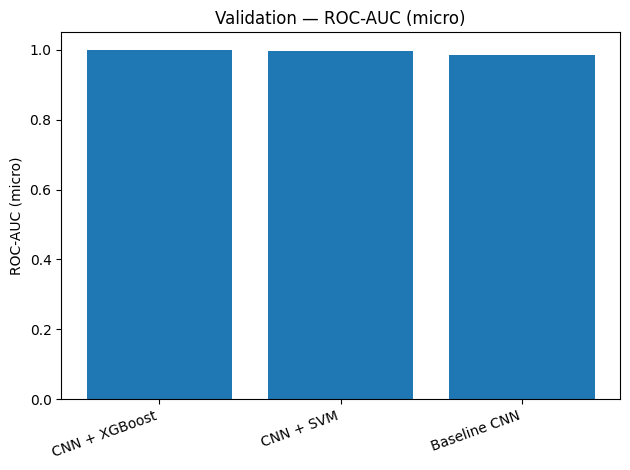

In [69]:

# ---------- 1) Learning curves ----------
OUTDIR = "./outputs"
os.makedirs(OUTDIR, exist_ok=True)
def plot_learning_curves(history, outdir=OUTDIR, show=True):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    # Accuracy
    plt.figure()
    plt.plot(acc, label="Train acc")
    plt.plot(val_acc, label="Val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Learning curve — accuracy"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(outdir, "learning_curve_accuracy.png"), dpi=150)
    if show: plt.show(); plt.close()

    # Loss
    plt.figure()
    plt.plot(loss, label="Train loss")
    plt.plot(val_loss, label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Learning curve — loss"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(outdir, "learning_curve_loss.png"), dpi=150)
    if show: plt.show(); plt.close()


plot_learning_curves(history)

# Bar chart for visual comparison of models
plt.figure()
plt.bar(res_df["Model"], res_df["F1_micro"])
plt.ylabel("F1 (micro)"); plt.title("Validation — F1 (micro)")
plt.xticks(rotation=20, ha="right"); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "bar_f1_micro.png"), dpi=150)
plt.show(); plt.close()

plt.figure()
plt.bar(res_df["Model"], res_df["ROC_AUC_micro"])
plt.ylabel("ROC-AUC (micro)"); plt.title("Validation — ROC-AUC (micro)")
plt.xticks(rotation=20, ha="right"); plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "bar_auc_micro.png"), dpi=150)
plt.show(); plt.close()

# Predictions on the Test set



In [ ]:
def load_unlabeled_images(folder: Path, img_size: int):
    files, imgs = [], []
    for p in sorted(folder.rglob("*.png")):
        if p.is_file():
            try:
                img = keras.utils.load_img(p, target_size=(img_size, img_size))
                arr = keras.utils.img_to_array(img)
                imgs.append(arr)
                files.append(p.name)
            except Exception as e:
                print(f"Skipping {p}: {e}")
    if not imgs:
        raise RuntimeError(f"No images found in {folder.resolve()}")
    return files, np.stack(imgs, 0).astype("float32")

TEST_DIR_PATH = Path(TEST_DIR)
files_test, Xtest = load_unlabeled_images(TEST_DIR_PATH, IMG_SIZE)
ds_unlab = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE).prefetch(AUTOTUNE)

prob_cnn_t = cnn.predict(ds_unlab, verbose=0)
pred_cnn_t = prob_cnn_t.argmax(1)
top_cnn_t = prob_cnn_t.max(1)

Ztest = feature_extractor.predict(ds_unlab, verbose=0)

prob_svm_t = svm_clf.predict_proba(Ztest)
pred_svm_t = prob_svm_t.argmax(1)
top_svm_t = prob_svm_t.max(1)

prob_xgb_t = xgb_clf.predict_proba(Ztest)
pred_xgb_t = prob_xgb_t.argmax(1)
top_xgb_t = prob_xgb_t.max(1)

model_tag = "XGBoost" if XGB_AVAILABLE else "GradientBoosting"
pred_df = pd.DataFrame({
    "file": files_test,
    "CNN_pred": [CLASS_NAMES[i] for i in pred_cnn_t],
    "CNN_conf": top_cnn_t,
    "SVM_pred": [CLASS_NAMES[i] for i in pred_svm_t],
    "SVM_conf": top_svm_t,
    f"{model_tag}_pred": [CLASS_NAMES[i] for i in pred_xgb_t],
    f"{model_tag}_conf": top_xgb_t,
}).sort_values("file").reset_index(drop=True)


print(f"\nPredictions generated for {len(files_test)} images in ./test")
display(pred_df)



Predictions generated for 794 images in ./test


,file,CNN_pred,CNN_conf,SVM_pred,SVM_conf,XGBoost_pred,XGBoost_conf
0,0021e90e4.png,Small-flowered Cranesbill,0.702792,Small-flowered Cranesbill,0.977800,Small-flowered Cranesbill,0.998807
1,003d61042.png,Fat Hen,0.870178,Fat Hen,0.960357,Fat Hen,0.997375
2,007b3da8b.png,Cleavers,0.366412,Sugar beet,0.424915,Sugar beet,0.827761
3,0086a6340.png,Common Chickweed,0.977824,Common Chickweed,0.974709,Common Chickweed,0.999287
4,00c47e980.png,Sugar beet,0.711129,Sugar beet,0.946384,Sugar beet,0.993631
...,...,...,...,...,...,...,...
789,fea355851.png,Loose Silky-bent,0.726118,Loose Silky-bent,0.935494,Loose Silky-bent,0.999021
790,fea3da57c.png,Sugar beet,0.866022,Sugar beet,0.986623,Sugar beet,0.998271
791,fef2ade8c.png,Sugar beet,0.890806,Sugar beet,0.982256,Sugar beet,0.998079
792,ff65bc002.png,Charlock,0.907293,Charlock,0.990363,Charlock,0.998580


In [32]:
pred_df.describe()

,CNN_conf,SVM_conf,XGBoost_conf
count,794.000000,794.000000,794.000000
mean,0.694228,0.833899,0.927744
std,0.193215,0.173991,0.138603
min,0.225243,0.223066,0.233034
25%,0.529164,0.747088,0.941928
50%,0.701160,0.912092,0.994438
75%,0.870065,0.969909,0.998737
max,0.999260,0.996833,0.999787


In [ ]:
# Save predictions
pred_df.to_csv("predictions.csv", index=False)